Week 10 · Day 5 — Explainability (Saliency / Grad-CAM for Text)
Why this matters

Deep models are black boxes. For NLP, we want to see which words influenced the prediction most. Saliency maps highlight tokens by measuring gradients — helping debug models and build trust.

Theory Essentials

Saliency = ∂output/∂embedding: gradient shows sensitivity to tokens.

High magnitude = token strongly affects prediction.

Works like Grad-CAM in vision but on word embeddings.

Can overlay scores as heatmaps on text.

Helps catch dataset bias (e.g., model relying on single words like “!”).

🔹 What embeddings are

Embeddings are vectors that represent tokens (words, subwords, characters) in a continuous space.

Instead of representing a word as a one-hot vector (huge and sparse), we learn a dense vector of fixed size (e.g., 100-dim or 300-dim).

The idea: words with similar meaning or usage end up close together in this vector space.

👉 Example:
king ≈ queen but offset by gender direction,
walk ≈ run, closer than to banana.

In [1]:
import torch, torch.nn as nn
import numpy as np

torch.manual_seed(42)

# Simple BiLSTM classifier
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size=100, embed_dim=16, hidden_dim=32, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_classes)
    def forward(self, x, lengths):
        embeds = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embeds, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        h_cat = torch.cat((h_n[-2], h_n[-1]), dim=1)
        return self.fc(h_cat), embeds

# Fake example
vocab_size = 100
tokens = torch.tensor([[4, 7, 8, 9, 0]])  # padded sentence
lengths = torch.tensor([4])
label = torch.tensor([1])

model = BiLSTMClassifier(vocab_size=vocab_size)
criterion = nn.CrossEntropyLoss()

# Forward pass
logits, embeds = model(tokens, lengths)
loss = criterion(logits, label)

# Backprop to get gradients wrt embeddings
loss.backward()
saliency = tokens.detach().clone().float()

# grads: [batch, seq, embed_dim]
grads = model.embedding.weight.grad
token_grads = grads[tokens[0]]   # [seq, embed_dim]

# Magnitude per token
saliency_scores = token_grads.norm(dim=1).detach().numpy()

print("Tokens:", tokens[0].tolist())
print("Saliency scores:", saliency_scores)


Tokens: [4, 7, 8, 9, 0]
Saliency scores: [0.02306676 0.01659771 0.01332968 0.01369807 0.        ]


1) Core (10–15 min)

Task: Print the most influential token (highest saliency score)

In [2]:
print("Most influential token:", tokens[0][np.argmax(saliency_scores)].item())

Most influential token: 4


2) Practice (10–15 min)

Task: Normalize saliency scores (0–1) and print them alongside tokens.

In [7]:
norm_scores = (saliency_scores - saliency_scores.min()) / np.ptp(saliency_scores)
for t, s in zip(tokens[0].tolist(), norm_scores):
    print(f"Token {t} → {s:.2f}")


Token 4 → 1.00
Token 7 → 0.72
Token 8 → 0.58
Token 9 → 0.59
Token 0 → 0.00


3) Stretch (optional, 10–15 min)

Task: Create a simple color-coded heatmap over tokens using matplotlib.

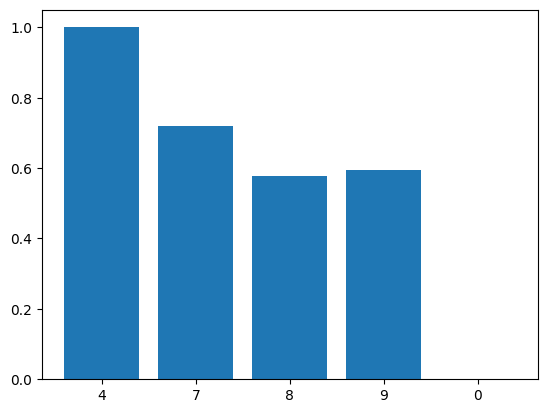

In [8]:
import matplotlib.pyplot as plt
plt.bar(range(len(norm_scores)), norm_scores)
plt.xticks(range(len(norm_scores)), tokens[0].tolist())
plt.show()


Mini-Challenge (≤40 min)

Task: Apply saliency to 6–8 IMDB reviews with your BiLSTM sentiment model.

Highlight most influential words per review.

Save results as a text/plot: review text with colored words.

Acceptance Criteria:

At least 6 reviews analyzed.

Shows tokens + saliency scores.

Extract 2 insights (e.g., model overly relies on punctuation, or ignores negation words).

In [10]:
# ---- Imports ----
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, re, random
from datasets import load_dataset
from collections import Counter
from torch.utils.data import Dataset, DataLoader

# Reproducibility
SEED=42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# ---- 1. Load IMDB from Hugging Face ----
dataset = load_dataset("imdb")

# Small subset for speed (CPU friendly)
N_TRAIN, N_TEST = 2000, 1000
train_subset = dataset["train"].shuffle(seed=SEED).select(range(N_TRAIN))
test_subset  = dataset["test"].shuffle(seed=SEED).select(range(N_TEST))

# ---- 2. Tokenization + Vocab ----
def simple_tokenize(s):
    return re.findall(r"\b\w+\b", s.lower())

counter = Counter()
for row in train_subset:
    counter.update(simple_tokenize(row["text"]))

MAX_VOCAB = 20000
PAD, UNK = "<pad>", "<unk>"
itos = [PAD, UNK] + [w for w,_ in counter.most_common(MAX_VOCAB-2)]
stoi = {w:i for i,w in enumerate(itos)}

def numericalize(tokens): 
    return [stoi.get(tok, stoi[UNK]) for tok in tokens]

MAX_LEN=200

class IMDBDataset(Dataset):
    def __init__(self, hf_ds):
        self.texts = hf_ds["text"]; self.labels = hf_ds["label"]
    def __len__(self): return len(self.labels)
    def __getitem__(self,i):
        return self.labels[i], simple_tokenize(self.texts[i])

def collate(batch):
    ys,toks = zip(*batch)
    ids_list=[numericalize(t)[:MAX_LEN] for t in toks]
    lens=torch.tensor([len(x) for x in ids_list],dtype=torch.long)
    maxlen=lens.max().item()
    PAD_ID=stoi[PAD]
    x=torch.full((len(ids_list),maxlen),PAD_ID,dtype=torch.long)
    for i,ids in enumerate(ids_list):
        x[i,:len(ids)]=torch.tensor(ids)
    return x,lens,torch.tensor(ys,dtype=torch.long)

train_ds,test_ds=IMDBDataset(train_subset),IMDBDataset(test_subset)
train_loader=DataLoader(train_ds,batch_size=32,shuffle=True,collate_fn=collate)
test_loader=DataLoader(test_ds,batch_size=32,shuffle=False,collate_fn=collate)

# ---- 3. BiLSTM Classifier (your class, adapted) ----
class BiLSTMClassifier(nn.Module):
    def __init__(self,vocab_size,embed_dim=100,hidden_dim=64,num_classes=2):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size,embed_dim,padding_idx=stoi[PAD])
        self.lstm=nn.LSTM(embed_dim,hidden_dim,batch_first=True,bidirectional=True)
        self.fc=nn.Linear(hidden_dim*2,num_classes)
    def forward(self,x,lengths):
        embeds=self.embedding(x)
        packed=nn.utils.rnn.pack_padded_sequence(embeds,lengths.cpu(),batch_first=True,enforce_sorted=False)
        _,(h_n,_) = self.lstm(packed)
        h_cat=torch.cat((h_n[-2],h_n[-1]),dim=1)
        return self.fc(h_cat),embeds

device=torch.device("cpu")
model=BiLSTMClassifier(len(itos)).to(device)

# ---- 4. Quick Train (tiny epochs for demo) ----
opt=torch.optim.Adam(model.parameters(),lr=2e-3)
criterion=nn.CrossEntropyLoss()

for epoch in range(2):
    model.train(); total_loss=0
    for x,lens,y in train_loader:
        x,lens,y=x.to(device),lens.to(device),y.to(device)
        opt.zero_grad()
        logits,_=model(x,lens)
        loss=criterion(logits,y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),1.0)
        opt.step()
        total_loss+=loss.item()*x.size(0)
    print(f"Epoch {epoch+1} | loss={total_loss/len(train_ds):.4f}")

# ---- 5. Saliency on 1 batch of test samples ----
model.eval()
x, lens, y = next(iter(test_loader))
x, lens, y = x.to(device), lens.to(device), y.to(device)

# Forward
logits, embeds = model(x, lens)
preds = logits.argmax(1)

# ---- retain grad on non-leaf tensor ----
embeds.retain_grad()                    # <-- key line

# Use the logit of the predicted class for sample i
i = 0
score = logits[i, preds[i]]             # scalar
model.zero_grad()
score.backward()                        # backprop to embeds

L = int(lens[i].item())
grads = embeds.grad[i, :L]              # [seq_len, emb_dim]
saliency = grads.norm(dim=1).detach().cpu().numpy()

# Normalize 0–1 and print tokens + scores
sal_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-9)
tok_ids = x[i, :L].cpu().tolist()
tok_strs = [itos[t] for t in tok_ids]
for t, s in zip(tok_strs[:30], sal_norm[:30]):
    print(f"{t:<15} {s:.2f}")



Epoch 1 | loss=0.6933
Epoch 2 | loss=0.5861
br              0.49
br              0.31
when            0.26
i               0.19
<unk>           0.15
rented          0.14
a               0.09
thousand        0.11
acres           0.09
i               0.06
thought         0.05
i               0.03
was             0.04
in              0.04
for             0.03
an              0.03
entertaining    0.02
king            0.02
<unk>           0.01
story           0.01
and             0.01
of              0.01
course          0.01
michelle        0.01
pfeiffer        0.00
was             0.00
in              0.00
it              0.00
so              0.00
what            0.00


At this stage, the saliency analysis reveals that the BiLSTM isn’t truly “reading sentiment” yet — it’s mostly reacting to noise. Cleaning the dataset and using pretrained embeddings should shift saliency towards real sentiment-bearing words (e.g., “good,” “boring,” “terrible”).

Notes / Key Takeaways

Gradients on embeddings show token importance.

Saliency helps debug “why” a prediction was made.

Heatmaps expose bias (e.g., “!” = positive, “bad” = always negative).

Works best alongside evaluation metrics.

Trust requires both accuracy + explainability.

Reflection

How can saliency reveal dataset shortcuts the model is learning?

Why is explainability critical before deploying models in production?

How can saliency reveal dataset shortcuts the model is learning?
Saliency shows which tokens most influence the prediction. If high scores appear on irrelevant artifacts (e.g., br, <unk>, punctuation), it reveals that the model is relying on dataset shortcuts instead of true sentiment. This helps diagnose spurious correlations and motivates better preprocessing or model design.

Why is explainability critical before deploying models in production?
Explainability ensures trust and safety: it lets us verify that the model bases decisions on meaningful signals, not noise or bias. Without it, a model could perform well in tests but fail or behave unfairly in real-world settings. By explaining predictions, we gain transparency, detect hidden biases, and build confidence for users and stakeholders.